In [21]:
# import module

import re
import urllib.request
import zipfile
import gensim
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm


<h2>1) 영어 Word2Vec 만들기</h2>

<h4>훈련데이터 준비</h4>

In [ ]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

In [2]:
#데이터 전처리
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]


In [ ]:
#정상적으로 실행됐다면 273424개의 샘플이 존재
print('총 샘플의 개수 : {}'.format(len(result)))

<h4>Word2Vec 훈련시키기</h4>

In [3]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [4]:
#man과 유사한 단어 출력
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8395764827728271), ('guy', 0.8172741532325745), ('boy', 0.7796651124954224), ('soldier', 0.7653211355209351), ('lady', 0.7619932889938354), ('gentleman', 0.7549223303794861), ('girl', 0.7409123778343201), ('kid', 0.7158980369567871), ('poet', 0.7060043811798096), ('writer', 0.6519165635108948)]


<h4>Word2Vec 모델 저장하고 로드하기</h4>

In [5]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [6]:
#load한 모델로 man과 유사한 단어 출력
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8395764827728271), ('guy', 0.8172741532325745), ('boy', 0.7796651124954224), ('soldier', 0.7653211355209351), ('lady', 0.7619932889938354), ('gentleman', 0.7549223303794861), ('girl', 0.7409123778343201), ('kid', 0.7158980369567871), ('poet', 0.7060043811798096), ('writer', 0.6519165635108948)]


<h2>2) 한국어 Word2Vec 만들기(네이버 영화 리뷰)</h2>

In [ ]:
#영화 리뷰 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

In [9]:
# 데이터프레임으로 저장 및 출력
train_data = pd.read_table('ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
#200000개
print(len(train_data)) # 리뷰 개수 출력

In [10]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [11]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data)) # 리뷰 개수 출력 # 199992개

False
199992


In [12]:
#정규 표현식을 통해 한국 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [15]:
# 불용어 제거

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


  0%|          | 0/199992 [00:00<?, ?it/s]

100%|██████████| 199992/199992 [12:45<00:00, 261.36it/s]


리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.338453538141525


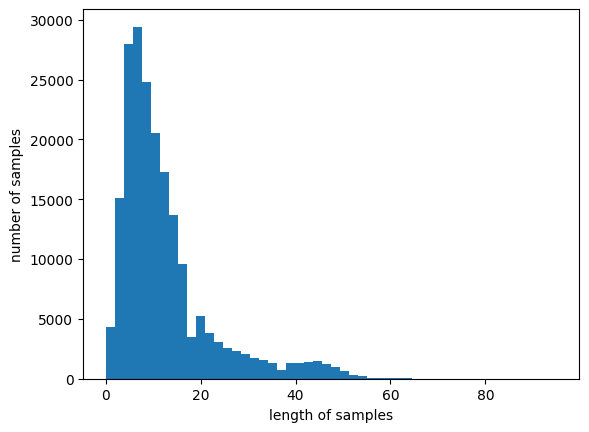

In [17]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 영화 리뷰 데이터 학습
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [19]:
# 최민식과 유사한 단어 출력
print(model.wv.most_similar("최민식"))

[('한석규', 0.861241340637207), ('박중훈', 0.8547206521034241), ('최민수', 0.837360680103302), ('안성기', 0.8292763233184814), ('송강호', 0.826386034488678), ('크로우', 0.8130457401275635), ('김혜수', 0.8073057532310486), ('류덕환', 0.8053721785545349), ('스트립', 0.8050442337989807), ('조진웅', 0.8041333556175232)]


<h2>3) 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개</h2>

In [22]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [23]:
#단어의 유사도 계산
print(word2vec_model.similarity('this', 'is')) # 'this'와 'is' 단어의 유사도 계산
print(word2vec_model.similarity('post', 'book')) # 'post'와 'book' 단어의 유사도 계산

0.40797037
0.057204384


In [24]:
print(word2vec_model['book']) # 단어 'book'의 벡터 출력

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04